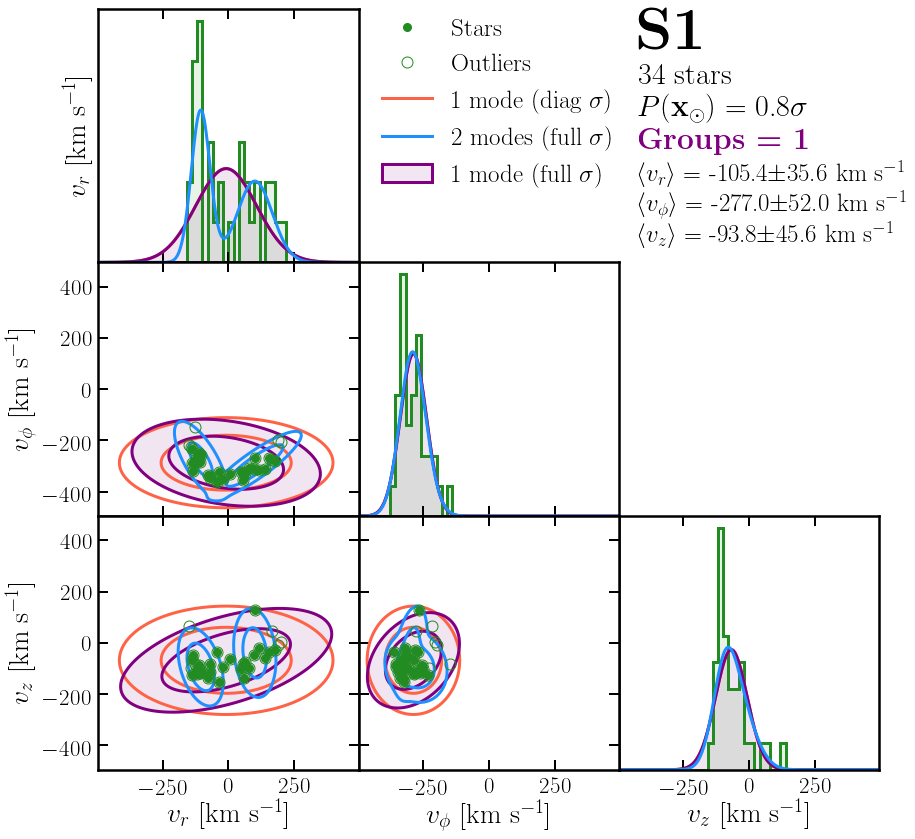

In [299]:
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
from sklearn import mixture
from PlotFuncs import *
import pandas
from scipy.special import erfinv


# input
vmin=-495.0
vmax=495.0
nfine=500
nbins_1D = 50
cmap=cm.Greens
levels=[-6.2,-2.3,0]
tit_fontsize=30
z_th = 6.0
col_hist='ForestGreen'
colp = 'ForestGreen'
col_a = 'tomato'
col_b = 'purple'
col_c = 'dodgerblue'
point_size = 8
RemoveOutliers = False
lblsize = 28
def_alph = 0.1


# df = pandas.read_csv('../GAIA_SDSS_substructures_next_30_cands.csv')
# names = df.group_id.unique()
# num_cands = size(names)

# i_cand = 2
# Cand = df.loc[df['group_id'] == names[i_cand]]

Cand = pandas.read_csv('../S1_only_cat_simple.csv')

######
name = Cand.group_id.unique()[0]
nstars = size(Cand,0)
feh = Cand.feh
vx,vy,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel
x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ
x_red,y_red,z_red,vx_red,vy_red,vz_red = RemovePhaseSpaceOutliers(x,y,z,vx,vy,vz,z_th=z_th)

if RemoveOutliers:
    data = array([vx_red,vy_red,vz_red]).T
    nstars = size(vx_red)
else:
    data = array([vx,vy,vz,feh]).T
    nstars = size(vx)
clfa = mixture.GaussianMixture(n_components=1, covariance_type='diag')
clfb = mixture.GaussianMixture(n_components=1, covariance_type='full')
clfc = mixture.GaussianMixture(n_components=2, covariance_type='full')

clfa.fit(data)
clfb.fit(data)
clfc.fit(data)

vfine = linspace(vmin,vmax,nfine)
V1,V2 = meshgrid(vfine,vfine)
    
def fv_1D(clf,i):
    covs = clf.covariances_
    meens = clf.means_
    fv = zeros(shape=nfine)
    if ndim(covs)>2:
        for k in range(0,shape(covs)[0]):
            sig0_sq = covs[k,i,i]
            v0 = meens[k,i]
            Norm = (1.0/sqrt(2*pi*sig0_sq))
            fv += Norm*exp(-(vfine-v0)**2.0/(2*sig0_sq))
    else:
        sig0_sq = covs[0,i]
        v0 = meens[0,i]
        Norm = (1.0/sqrt(2*pi*sig0_sq))
        fv = Norm*exp(-(vfine-v0)**2.0/(2*sig0_sq))
    fv /= trapz(fv,vfine)
    return fv
                    
    
def fv_2D(clf,i,j):
    covs = clf.covariances_
    meens = clf.means_
    fv = zeros(shape=(nfine,nfine))
    if ndim(covs)>2:
        for k in range(0,shape(covs)[0]):
            v10 = meens[k,i]
            v20 = meens[k,j]
            Sig_inv = linalg.inv(covs[k,:,:])
            V1o = V1-v10
            V2o = V2-v20
            Norm = sqrt(Sig_inv[j,j]*Sig_inv[j,j])/(2*pi)
            fv += Norm*exp(-0.5*(V1o**2.0*Sig_inv[i,i]+V2o**2.0*Sig_inv[j,j]+2*V1o*V2o*Sig_inv[j,i]))
    else:
        v10 = meens[0,i]
        v20 = meens[0,j]
        Sig_inv = 1.0/covs
        V1o = V1-v10
        V2o = V2-v20
        Norm = sqrt(Sig_inv[0,j]*Sig_inv[0,i])/(2*pi)
        fv = Norm*exp(-0.5*(V1o**2.0*Sig_inv[0,i]+V2o**2.0*Sig_inv[0,j]))
    fv = log(fv)
    fv = fv-amax(fv)
    return fv
    

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axarr = plt.subplots(3, 3,figsize=(14,14))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.0,hspace=0.0)
ax_x = plt.subplot(gs[0,0])
ax_y = plt.subplot(gs[1,1])
ax_z = plt.subplot(gs[2,2])

ax_yx = plt.subplot(gs[1,0])
ax_zx = plt.subplot(gs[2,0])
ax_zy = plt.subplot(gs[2,1])

fig.delaxes(plt.subplot(gs[0,1]))
fig.delaxes(plt.subplot(gs[0,2]))
fig.delaxes(plt.subplot(gs[1,2]))

# 1D plots
plt.sca(ax_x)
ax_x.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,alpha=def_alph,normed=1)
plt.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,histtype='step',normed=1)
plt.plot(vfine,fv_1D(clfa,0),'-',linewidth=3,color=col_a)
plt.plot(vfine,fv_1D(clfb,0),'-',linewidth=3,color=col_b)
plt.plot(vfine,fv_1D(clfc,0),'-',linewidth=3,color=col_c)
#plt.title(r'$\langle v_r \rangle= $ '+str(int(vx0))+r' km s$^{-1}$',fontsize=tit_fontsize)
plt.ylabel(r'$v_r$ [km s$^{-1}$]',fontsize=lblsize)

plt.sca(ax_y)
ax_y.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,alpha=def_alph,normed=1)
plt.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,histtype='step',normed=1)
plt.plot(vfine,fv_1D(clfa,1),'-',linewidth=3,color=col_a)
plt.plot(vfine,fv_1D(clfb,1),'-',linewidth=3,color=col_b)
plt.plot(vfine,fv_1D(clfc,1),'-',linewidth=3,color=col_c)
#plt.title(r'$\langle v_\phi \rangle = $ '+str(int(vy0))+r' km s$^{-1}$',fontsize=tit_fontsize)

plt.sca(ax_z)
ax_z.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,alpha=def_alph,normed=1)
plt.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,histtype='step',normed=1)
plt.plot(vfine,fv_1D(clfa,2),'-',linewidth=3,color=col_a)
plt.plot(vfine,fv_1D(clfb,2),'-',linewidth=3,color=col_b)
plt.plot(vfine,fv_1D(clfc,2),'-',linewidth=3,color=col_c)
#plt.title(r'$\langle v_z \rangle= $ '+str(int(vz0))+r' km s$^{-1}$',fontsize=tit_fontsize)
plt.xlabel(r'$v_z$ [km s$^{-1}$]',fontsize=lblsize)


# 2D plots
plt.sca(ax_yx)
ax_yx.plot(vx_red,vy_red,'o',markersize=point_size,markerfacecolor=colp,markeredgecolor=colp,label='Stars')
ax_yx.plot(vx,vy,'o',markersize=point_size+3,markerfacecolor='none',markeredgecolor=colp,label='Outliers')
ax_yx.contour(vfine,vfine,fv_2D(clfa,0,1),levels=levels,colors=col_a,linewidths=3,linestyles='solid')
ax_yx.contour(vfine,vfine,fv_2D(clfb,0,1),levels=levels,colors=col_b,linewidths=3,linestyles='solid')
ax_yx.contour(vfine,vfine,fv_2D(clfc,0,1),levels=levels,colors=col_c,linewidths=3,linestyles='solid')
plt.ylabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=lblsize)

plt.sca(ax_zx)
ax_zx.plot(vx_red,vz_red,'o',markersize=point_size,markerfacecolor=colp,markeredgecolor=colp)
ax_zx.plot(vx,vz,'o',markersize=point_size+3,markerfacecolor='none',markeredgecolor=colp)
ax_zx.contour(vfine,vfine,fv_2D(clfa,0,2),levels=levels,colors=col_a,linewidths=3,linestyles='solid')
ax_zx.contour(vfine,vfine,fv_2D(clfb,0,2),levels=levels,colors=col_b,linewidths=3,linestyles='solid')
ax_zx.contour(vfine,vfine,fv_2D(clfc,0,2),levels=levels,colors=col_c,linewidths=3,linestyles='solid')
plt.xlabel(r'$v_r$ [km s$^{-1}$]',fontsize=lblsize)
plt.ylabel(r'$v_z$ [km s$^{-1}$]',fontsize=lblsize)

plt.sca(ax_zy)
ax_zy.plot(vy_red,vz_red,'o',markersize=point_size,markerfacecolor=colp,markeredgecolor=colp)
ax_zy.plot(vy,vz,'o',markersize=point_size+3,markerfacecolor='none',markeredgecolor=colp)
ax_zy.contour(vfine,vfine,fv_2D(clfa,1,2),levels=levels,colors=col_a,linewidths=3,linestyles='solid')
ax_zy.contour(vfine,vfine,fv_2D(clfb,1,2),levels=levels,colors=col_b,linewidths=3,linestyles='solid')
ax_zy.contour(vfine,vfine,fv_2D(clfc,1,2),levels=levels,colors=col_c,linewidths=3,linestyles='solid')
plt.xlabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=lblsize)

ax_x.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=23)
ax_y.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=23)
ax_z.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=23)
ax_zx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=23)
ax_yx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=23)
ax_zy.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=23)


ax_yx.set_xlim([vmin,vmax])
ax_yx.set_ylim([vmin,vmax])

ax_zx.set_xlim([vmin,vmax])
ax_zx.set_ylim([vmin,vmax])

ax_zy.set_xlim([vmin,vmax])
ax_zy.set_ylim([vmin,vmax])

ax_x.set_xlim([vmin,vmax])
ax_y.set_xlim([vmin,vmax])
ax_z.set_xlim([vmin,vmax])

ax_x.set_yticks([])
ax_y.set_yticks([])
ax_z.set_yticks([])
ax_x.set_yticklabels([])
ax_x.set_xticklabels([])
ax_y.set_yticklabels([])
ax_y.set_xticklabels([])
ax_z.set_yticklabels([])
ax_yx.set_xticklabels([])
ax_zy.set_yticklabels([])

xlab = 0.66
plt.gcf().text(xlab, 0.84, r'\bf {'+name+r'}', fontsize=60)
plt.gcf().text(xlab,0.805,str(nstars)+' stars',fontsize=30)
#plt.gcf().text(x_lab,0.8,r'$\langle$[Fe/H]$\rangle$ = '+r'{:.2f}'.format(mean(feh)),fontsize=30)  

# Sun overlap
clf_xyz = mixture.GaussianMixture(n_components=1, covariance_type='full')
clf_xyz.fit(array([x,y,z]).T)
lsun = clf_xyz.score_samples(Sun.reshape(-1,1).T)
xyz_meens = clf_xyz.means_
lmax = clf_xyz.score_samples(xyz_meens)
dL = -2*(lsun-lmax)
Psun = 1-chi2.cdf(dL,3)

plt.gcf().text(xlab,0.77,r'$P(\mathbf{x}_\odot)$ = '+'{:.1f}'.format(sqrt(2)*erfinv(Psun[0]))+r'$\sigma$',fontsize=30)

#r'$\langle v_r \rangle $ = '\+'{:.1f}'.format(meens[0,0])+'$\pm$'+'{:.1f}'.format(sqrt(covs[0,0,0]))+' km s$^{-1}$',fontsize=25)   

# "LEGEND"
bics = array([0.0,0.0,0.0])
data = array([x,y,z,vx,vy,vz,feh]).T
clfa_full = mixture.GaussianMixture(n_components=1, covariance_type='diag')
clfb_full = mixture.GaussianMixture(n_components=1, covariance_type='full')
clfc_full = mixture.GaussianMixture(n_components=2, covariance_type='full')
clfa_full.fit(data)
clfb_full.fit(data)
clfc_full.fit(data)
bics[0] = clfa_full.bic(data)
bics[1] = clfb_full.bic(data)
bics[2] = clfc_full.bic(data)

min_ic= min(bica,bicb,bicc)
def col_alpha(col,alpha=def_alph):
    rgb = colors.colorConverter.to_rgb(col)
    bg_rgb = [1,1,1]
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# check if groups overlap and bimodal is overfitting
if min_ic==bicc:
    covs = clfc.covariances_
    meens = clfc.means_
    chck = 0
    for k in range(0,3):
        dsig = sqrt(covs[0,k,k])+sqrt(covs[1,k,k])
        dv = abs(meens[0,k]-meens[1,k])
        if dv>dsig:
            chck += chck
    if chck<3:
        bics[1] = -10000.0
        
label_a = '1 mode (diag $\sigma$)'
label_b = '1 mode (full $\sigma$)'
label_c = '2 modes (full $\sigma$)'
if argmin(bics)==0:
    ax_x.fill_between(vfine,fv_1D(clfa,0),facecolor=col_a,alpha=def_alph,zorder=-5)
    ax_y.fill_between(vfine,fv_1D(clfa,1),facecolor=col_a,alpha=def_alph,zorder=-5)
    ax_z.fill_between(vfine,fv_1D(clfa,2),facecolor=col_a,alpha=def_alph,zorder=-5)
    ax_yx.contourf(vfine,vfine,fv_2D(clfa,0,1),levels=levels,colors=col_a,alpha=def_alph,zorder=-5)
    ax_zx.contourf(vfine,vfine,fv_2D(clfa,0,2),levels=levels,colors=col_a,alpha=def_alph,zorder=-5)
    ax_zy.contourf(vfine,vfine,fv_2D(clfa,1,2),levels=levels,colors=col_a,alpha=def_alph,zorder=-5)
elif argmin(bics)==1:
    ax_x.fill_between(vfine,fv_1D(clfb,0),facecolor=col_b,alpha=def_alph,zorder=-5)
    ax_y.fill_between(vfine,fv_1D(clfb,1),facecolor=col_b,alpha=def_alph,zorder=-5)
    ax_z.fill_between(vfine,fv_1D(clfb,2),facecolor=col_b,alpha=def_alph,zorder=-5)
    ax_yx.contourf(vfine,vfine,fv_2D(clfb,0,1),levels=levels,colors=col_b,alpha=def_alph,zorder=-5)
    ax_zx.contourf(vfine,vfine,fv_2D(clfb,0,2),levels=levels,colors=col_b,alpha=def_alph,zorder=-5)
    ax_zy.contourf(vfine,vfine,fv_2D(clfb,1,2),levels=levels,colors=col_b,alpha=def_alph,zorder=-5)
    
    plt.sca(ax_yx)
    ax_yx.plot(10*vmin,-10*vmin,'-',lw=3,color=col_a,label=label_a,zorder=-10)
    ax_yx.fill_between(-10000*vfine/vfine,-1000*vfine/vfine,y2=-10000,lw=3,edgecolor=col_b,facecolor=col_alpha(col_b),label=label_b,zorder=-1)
    ax_yx.plot(10*vmin,-10*vmin,'-',lw=3,color=col_c,label=label_c,zorder=5)
    plt.gcf().text(xlab,0.74,r'{\bf Groups = 1}',fontsize=30,color=col_b) 
    
    covs = clfc.covariances_
    meens = clfc.means_
    plt.gcf().text(xlab,0.705,r'$\langle v_r \rangle $ = '\
                   +'{:.1f}'.format(meens[0,0])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[0,0,0]))\
                   +' km s$^{-1}$',fontsize=25)           
    plt.gcf().text(xlab,0.675,r'$\langle v_\phi \rangle $ = '\
                   +'{:.1f}'.format(meens[0,1])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[0,1,1]))\
                   +' km s$^{-1}$',fontsize=25)            
    plt.gcf().text(xlab,0.645,r'$\langle v_z \rangle $ = '\
                   +'{:.1f}'.format(meens[0,2])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[0,2,2]))\
                   +' km s$^{-1}$',fontsize=25) 
else:
    ax_x.fill_between(vfine,fv_1D(clfc,0),facecolor=col_c,alpha=def_alph,zorder=-5)
    ax_y.fill_between(vfine,fv_1D(clfc,1),facecolor=col_c,alpha=def_alph,zorder=-5)
    ax_z.fill_between(vfine,fv_1D(clfc,2),facecolor=col_c,alpha=def_alph,zorder=-5)
    ax_yx.contourf(vfine,vfine,fv_2D(clfc,0,1),levels=levels,colors=col_c,alpha=def_alph,zorder=-5)
    ax_zx.contourf(vfine,vfine,fv_2D(clfc,0,2),levels=levels,colors=col_c,alpha=def_alph,zorder=-5)
    ax_zy.contourf(vfine,vfine,fv_2D(clfc,1,2),levels=levels,colors=col_c,alpha=def_alph,zorder=-5)
               
    plt.sca(ax_yx)
    ax_yx.plot(10*vmin,-10*vmin,'-',lw=3,color=col_a,label=label_a)
    ax_yx.plot(10*vmin,-10*vmin,'-',lw=3,color=col_b,label=label_b)
    ax_yx.fill_between(-10000*vfine/vfine,-1000*vfine/vfine,y2=-10000,lw=3,edgecolor=col_c,facecolor=col_alpha(col_c),label=label_c)
    covs = clfc.covariances_
    meens = clfc.means_
    plt.gcf().text(xlab,0.705,r'$\langle v_r \rangle $ = '\
                   +'{:.1f}'.format(meens[0,0])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[0,0,0]))\
                   +' km s$^{-1}$',fontsize=23)           
    plt.gcf().text(xlab,0.675,r'$\langle v_\phi \rangle $ = '\
                   +'{:.1f}'.format(meens[0,1])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[0,1,1]))\
                   +' km s$^{-1}$',fontsize=23)            
    plt.gcf().text(xlab,0.645,r'$\langle v_z \rangle $ = '\
                   +'{:.1f}'.format(meens[0,2])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[0,2,2]))\
                   +' km s$^{-1}$',fontsize=23)  
    
    plt.gcf().text(xlab,0.79,r'$\langle v_r \rangle $ = '\
                   +'{:.1f}'.format(meens[1,0])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[1,0,0]))\
                   +' km s$^{-1}$',fontsize=23)           
    plt.gcf().text(xlab,0.56,r'$\langle v_\phi \rangle $ = '\
                   +'{:.1f}'.format(meens[1,1])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[1,1,1]))\
                   +' km s$^{-1}$',fontsize=23)            
    plt.gcf().text(xlab,0.53,r'$\langle v_z \rangle $ = '\
                   +'{:.1f}'.format(meens[1,2])\
                   +'$\pm$'+'{:.1f}'.format(sqrt(covs[1,2,2]))\
                   +' km s$^{-1}$',fontsize=23) 

    plt.gcf().text(xlab,0.74,r'{\bf Groups = 2}',fontsize=30,color=col_c) 

    
    
plt.legend(fontsize=lblsize-3,frameon=False,bbox_to_anchor=(1.05, 2.0), loc=2, borderaxespad=0.)

# SunOverlap = in_hull(Sun,transpose(array([x,y,z])))
# if SunOverlap:
#     plt.gcf().text(0.66,0.675,r'Sun in full hull?' ,fontsize=30,color='ForestGreen')
# else:
#     plt.gcf().text(0.66,0.675,r'Sun in full hull?',fontsize=30,color='Crimson')

# SunOverlap = in_hull(Sun,transpose(array([x_red,y_red,z_red])))
# if SunOverlap:
#     plt.gcf().text(0.66,0.64,r'Sun in reduced hull?' ,fontsize=30,color='ForestGreen')
# else:
#     plt.gcf().text(0.66,0.64,r'Sun in reduced hull?',fontsize=30,color='Crimson')

fig.savefig('../plots/stars/Vtriangle_'+name+'.pdf',bbox_inches='tight')  
plt.show()

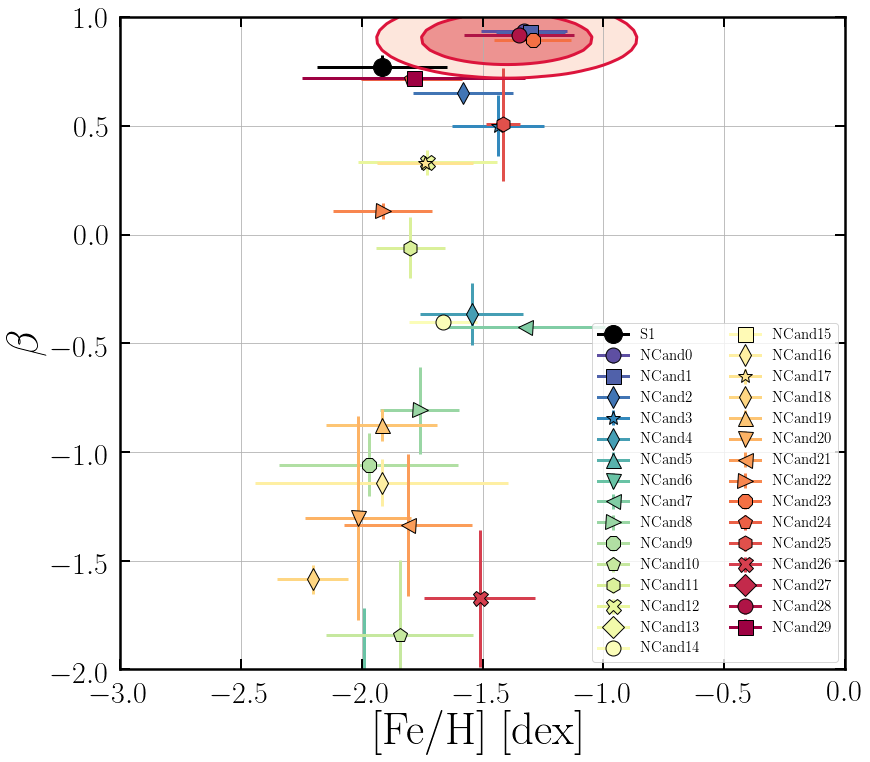

In [317]:
from scipy.stats import moment

def sigsig(x):
    n = size(x)
    return sqrt(sqrt(moment(x,4)/(n*1.0)-std(x)*(n-3)/((n-1.0)*n)))

fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)

nbins = 100

betamin = -2.0
betamax = 1.0
fehmin = -3.0
fehmax = 0.0

colsubs = flipud(cm.Spectral(linspace(0.0,1.0,num_cands)))

# S1 beta and metallicity
S1 = pandas.read_csv('../S1_only_cat_simple.csv')
vr,vphi,vz = S1.GalRVel,S1.GalTVel,S1.GalzVel
sigr,sigphi,sigz = std(vr),std(vphi),std(vz)
beta_stars = 1.0-(vphi**2.0+vz**2.0)/(2*vr**2.0)
sigr = std(S1.GalRVel)
sigphi = std(S1.GalTVel)
sigz = std(S1.GalzVel)
sigsigr = sigsig(S1.GalRVel)
sigsigphi = sigsig(S1.GalTVel)
sigsigz = sigsig(S1.GalzVel)
feh_S1 = mean(S1.feh)
feh_S1_err = std(S1.feh)
beta_S1 = 1-(sigphi**2.0+sigz**2.0)/(2*sigr**2.0)
betas_S1_err = ((sigphi**2.0+sigz**2.0)*sigsigr/sigr**3.0)-(sigphi*sigsigphi/sigr**2.0)-(sigz*sigsigz/sigr**2.0)
plt.errorbar(feh_S1,beta_S1,xerr=feh_S1_err,yerr=betas_S1_err,markersize=18,color='k',
             marker='o',linewidth=3,markeredgecolor='k',label='S1')



# Rest of objects
mrkz = ['o','s','d','*','d','^','v','<','>','8','p','h','X','D',]
nm = size(mrkz)

fehs = zeros(shape=num_cands)
betas = zeros(shape=num_cands)
fehs_err = zeros(shape=num_cands)
betas_err = zeros(shape=num_cands)
for i in range(0,num_cands):
    Cand = df.loc[df['group_id'] == names[i]]
    vr,vphi,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel
    sigr,sigphi,sigz = std(vr),std(vphi),std(vz)
    beta_stars = 1.0-(vphi**2.0+vz**2.0)/(2*vr**2.0)
    sigr = std(Cand.GalRVel)
    sigphi = std(Cand.GalTVel)
    sigz = std(Cand.GalzVel)
    fehs[i] = mean(Cand.feh)
    fehs_err[i] = std(Cand.feh)
    betas[i] = 1-(sigphi**2.0+sigz**2.0)/(2*sigr**2.0)
    sigsigr = sigsig(Cand.GalRVel)
    sigsigphi = sigsig(Cand.GalTVel)
    sigsigz = sigsig(Cand.GalzVel)
    betas_err[i] = ((sigphi**2.0+sigz**2.0)*sigsigr/sigr**3.0)-(sigphi*sigsigphi/sigr**2.0)-(sigz*sigsigz/sigr**2.0)
    plt.errorbar(fehs[i],betas[i],xerr=fehs_err[i],yerr=betas_err[i],markersize=15,color=colsubs[i,:],
                 marker=mrkz[mod(i,nm)],linewidth=3,markeredgecolor='k',label=names[i])
    
feh_vals = linspace(fehmin,fehmax,nbins)
beta_vals = linspace(betamin,betamax,nbins)
Feh_vals,Beta_vals = meshgrid(feh_vals,beta_vals)
feh_saus = -1.4
sig_feh_saus = 0.3
beta_saus = 0.9
sig_beta_saus = 0.1             
Saus = exp(-(Feh_vals-feh_saus)**2.0/(2*sig_feh_saus**2.0)-(Beta_vals-beta_saus)**2.0/(2*sig_beta_saus**2.0))
plt.contourf(feh_vals,beta_vals,Saus,'-',levels=[0.2,0.5,1.0],linewidths=3,cmap=cm.Reds,alpha=0.5)
plt.contour(feh_vals,beta_vals,Saus,'-',levels=[0.2,0.5,1.0],linewidths=3,colors='Crimson')
leg = plt.legend(loc='lower right',fontsize=15,ncol=2)

ax.grid()
ax.set_xlim(left=fehmin,right=fehmax)
ax.set_ylim(bottom=betamin,top=betamax)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"[Fe/H] [dex]",fontsize=45);
plt.ylabel(r"$\beta$",fontsize=45);

plt.show()

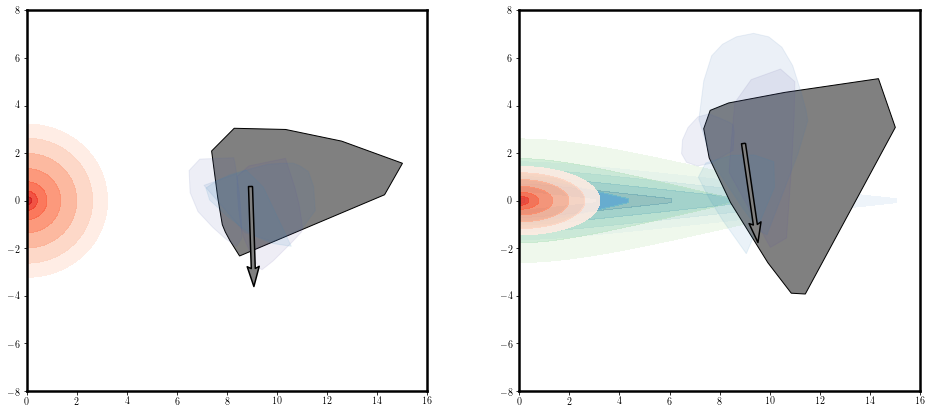

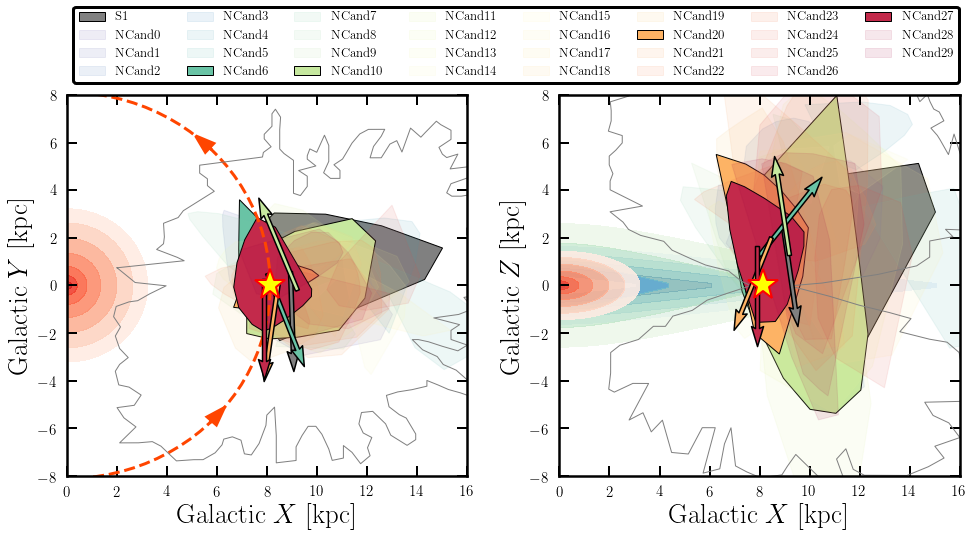

In [370]:
colsubs = flipud(cm.Spectral(linspace(0.0,1.0,num_cands)))
BulgeColour = 'Crimson'
DiskColour = 'Blue'
cmap = cm.Greens
xmin = 0.0
xmax = 16.0
Grid = False
z_th = .0
n_refinements = 1
alpha_in = 1.0
alpha_out = 0.1
Footprint = True
arrow_scale = 4.0




# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axarr = plt.subplots(1, 2,figsize=(16,7))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.23)
ax_xy = plt.subplot(gs[0])
ax_xz = plt.subplot(gs[1])

# Bulge and disk
xvals = linspace(0.0,xmax,100)
zvals = linspace(-xmax/2.0,xmax/2.0,100)
xx,zz = meshgrid(xvals,zvals)
R = sqrt(xx**2.0+zz**2.0)
rp = sqrt(R**2.0+(zz/0.5)**2.0)
rho_bulge = 95.6/((1.0+(rp/0.075))**1.8)*exp(-(rp/2.1)**2.0)
rho_bulge_xy = 95.6/((1.0+(R/0.075))**1.8)*exp(-(R/2.1)**2.0)

rho_thind = 816.6/(2*0.3)*exp(-abs(zz)/0.3 - R/2.6)
rho_thickd = 209.5/(2*0.9)*exp(-abs(zz)/0.9 - R/3.6)
rhomin = 0.5
ax_xz.contourf(xvals,zvals,log10(rho_thind),levels=arange(rhomin,3.0,0.5),cmap=cm.Blues,alpha=0.5,zorder=-1)
ax_xz.contourf(xvals,zvals,log10(rho_thickd),levels=arange(rhomin,3.0,0.5),cmap=cm.GnBu,alpha=0.5,zorder=-1)
ax_xz.contourf(xvals,zvals,log10(rho_bulge),levels=arange(-2,3,0.5),cmap=cm.Reds,alpha=0.9,zorder=-1)
ax_xy.contourf(xvals,zvals,log10(rho_bulge_xy),levels=arange(-2,3,0.5),cmap=cm.Reds,alpha=0.9,zorder=-1)

# S1
x,y,z = S1.GalRecX,S1.GalRecY,S1.GalRecZ
U,V,W = S1.GalU,S1.GalV,S1.GalW
points = transpose(array([x,y]))
hull = ConvexHull(points)
x_edge = points[hull.vertices,0]
y_edge = points[hull.vertices,1]
hull_smooth = chaikins_corner_cutting(x_edge,y_edge,refinements=n_refinements)
ax_xy.fill(hull_smooth[:,0],hull_smooth[:,1],alpha=alpha_in,facecolor='gray',zorder=0,label='S1',edgecolor='k')

points = transpose(array([x,z]))
hull = ConvexHull(points)
x_edge = points[hull.vertices,0]
z_edge = points[hull.vertices,1]
hull_smooth = chaikins_corner_cutting(x_edge,z_edge,refinements=n_refinements)
ax_xz.fill(hull_smooth[:,0],hull_smooth[:,1],alpha=alpha_in,facecolor='gray',zorder=0,edgecolor='k')

vstr = sqrt(mean(U)**2.0+mean(V)**2.0)
ax_xy.quiver(mean(x),mean(y),mean(U)/vstr,mean(V)/vstr,\
            color='gray',scale=arrow_scale,units='width',linewidth=1.5,edgecolor='k',width=0.01,zorder=5)
vstr = sqrt(mean(U)**2.0+mean(W)**2.0)
ax_xz.quiver(mean(x),mean(z),mean(U)/vstr,mean(W)/vstr,\
            color='gray',scale=arrow_scale,units='width',linewidth=1.5,edgecolor='k',width=0.01,zorder=5)



for i in range(0,num_cands):
    name = names[i]
    Cand = df.loc[df['group_id'] == name]
    StarsColour = colsubs[i,:]

    name = Cand.group_id.unique()[0]
    nstars = size(Cand,0)
    x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ
    U,V,W = Cand.GalU,Cand.GalV,Cand.GalW

    # reduced points
    x_red,y_red,z_red,U_red,V_red,W_red = RemovePhaseSpaceOutliers(x,y,z,U,V,W,z_th=z_th)
        
    # Check if Sun in reduced hull
    SunOverlap = in_hull(Sun,transpose(array([x_red,y_red,z_red])))
    if SunOverlap:
        alpha = alpha_in
        edgecolor = 'k'
    else:
        alpha = alpha_out
        edgecolor = StarsColour
    
    # Convex hull reduced
    points = transpose(array([x_red,y_red]))
    hull = ConvexHull(points)
    x_edge = points[hull.vertices,0]
    y_edge = points[hull.vertices,1]
    hull_smooth = chaikins_corner_cutting(x_edge,y_edge,refinements=n_refinements)
    ax_xy.fill(hull_smooth[:,0],hull_smooth[:,1],alpha=alpha,facecolor=StarsColour,zorder=0,label=name,edgecolor=edgecolor)
    
    points = transpose(array([x_red,z_red]))
    hull = ConvexHull(points)
    x_edge = points[hull.vertices,0]
    z_edge = points[hull.vertices,1]
    hull_smooth = chaikins_corner_cutting(x_edge,z_edge,refinements=n_refinements)
    ax_xz.fill(hull_smooth[:,0],hull_smooth[:,1],alpha=alpha,facecolor=StarsColour,zorder=0,edgecolor=edgecolor)

    if SunOverlap:
        vstr = sqrt(mean(U_red)**2.0+mean(V_red)**2.0)
        ax_xy.quiver(mean(x_red),mean(y_red),mean(U_red)/vstr,mean(V_red)/vstr,\
                    color=StarsColour,scale=arrow_scale,units='width',linewidth=1.5,edgecolor='k',width=0.01,zorder=5)
        vstr = sqrt(mean(U_red)**2.0+mean(W_red)**2.0)
        ax_xz.quiver(mean(x_red),mean(z_red),mean(U_red)/vstr,mean(W_red)/vstr,\
                    color=StarsColour,scale=arrow_scale,units='width',linewidth=1.5,edgecolor='k',width=0.01,zorder=5)


# bulge 
r_bulge = 3.0
th = linspace(-pi,pi,100)
#ax_xy.fill(r_bulge*cos(th),r_bulge*sin(th),color=BulgeColour,alpha=0.3)
#ax_xz.fill(r_bulge*cos(th),r_bulge*sin(th),color=BulgeColour,alpha=0.3)

# disk
#z_thick = 1.5
#z_thin = 0.3
#ax_xz.fill_between([xmin,xmax],[z_thick,z_thick],y2=-z_thick,color=DiskColour,alpha=0.3)
#ax_xz.fill_between([xmin,xmax],[z_thin,z_thin],y2=-z_thin,color=DiskColour,alpha=0.3)

# The sun
ax_xy.plot(Sun[0]*cos(th),Sun[0]*sin(th),'--',linewidth=3,color='orangered')
ax_xy.plot(Sun[0],Sun[1],'*',markerfacecolor='yellow',markersize=32,markeredgecolor='red',markeredgewidth=2,zorder=5)
ax_xz.plot(Sun[0],Sun[2],'*',markerfacecolor='yellow',markersize=32,markeredgecolor='red',markeredgewidth=2,zorder=5)

x1 = Sun[0]*cos(-pi/4)
y1 = Sun[0]*sin(-pi/4)
x2 = Sun[0]*cos(-pi/4+0.1)
y2 = Sun[0]*sin(-pi/4+0.1)
ax_xy.arrow(x1,y1,x2-x1,y2-y1,color='orangered',lw=3,length_includes_head=True,head_width=0.5)

x1 = Sun[0]*cos(pi/4)
y1 = Sun[0]*sin(pi/4)
x2 = Sun[0]*cos(pi/4+0.1)
y2 = Sun[0]*sin(pi/4+0.1)
ax_xy.arrow(x1,y1,x2-x1,y2-y1,color='orangered',lw=3,length_includes_head=True,head_width=0.5)


# legend
leg = ax_xy.legend(loc='upper left',ncol=8,fontsize=13,bbox_to_anchor=(0.0, 1.25),framealpha=1.0,edgecolor='k')
leg.get_frame().set_linewidth(3)

# xy labels
ax_xy.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=15)
ax_xy.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax_xy.set_xlabel(r"Galactic $X$ [kpc]",fontsize=27);
ax_xy.set_ylabel(r"Galactic $Y$ [kpc]",fontsize=27);

# xz labels
ax_xz.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=15)
ax_xz.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax_xz.set_xlabel(r"Galactic $X$ [kpc]",fontsize=27);
ax_xz.set_ylabel(r"Galactic $Z$ [kpc]",fontsize=27);

if Grid:
    phi = linspace(-pi/2,pi/2,7)
    xvals = linspace(xmin,xmax,100)
    rvals = arange(xmin,xmax*1.5,2.0)
    nr = size(rvals)
    zvals = arange(-xmax,xmax,2.0)
    nz = size(zvals)
    for ii in range(0,7):
        ax_xy.plot(xvals,xvals*tan(phi[ii]),'-',color='gray',lw=0.5)
    for ii in range(0,nr):
        ax_xy.plot(rvals[ii]*cos(th),rvals[ii]*sin(th),'-',color='gray',lw=0.5)
        ax_xz.plot(rvals[ii]*cos(th),rvals[ii]*sin(th),'-',color='gray',lw=0.5)
    for ii in range(0,nz):
        ax_xz.plot([xmin,xmax],[zvals[ii],zvals[ii]],'-',color='gray',lw=0.5)
    ax_xy.set_yticks(arange(-xmax,xmax,2.0))
    ax_xz.set_yticks(arange(-xmax,xmax,2.0))

ax_xy.set_xlim([xmin,xmax])
ax_xy.set_ylim([-xmax/2.0,xmax/2.0])
ax_xz.set_xlim([xmin,xmax])
ax_xz.set_ylim([-xmax/2.0,xmax/2.0])

if Footprint:
    footprint_XY = loadtxt('../GAIA-SDSS_footprint_XY.txt')
    ax_xy.plot(footprint_XY[:,0],footprint_XY[:,1],'-',color='gray',lw=1.0)
    footprint_XZ = loadtxt('../GAIA-SDSS_footprint_XZ.txt')
    ax_xz.plot(footprint_XZ[:,0],footprint_XZ[:,1],'-',color='gray',lw=1.0)


plt.show()

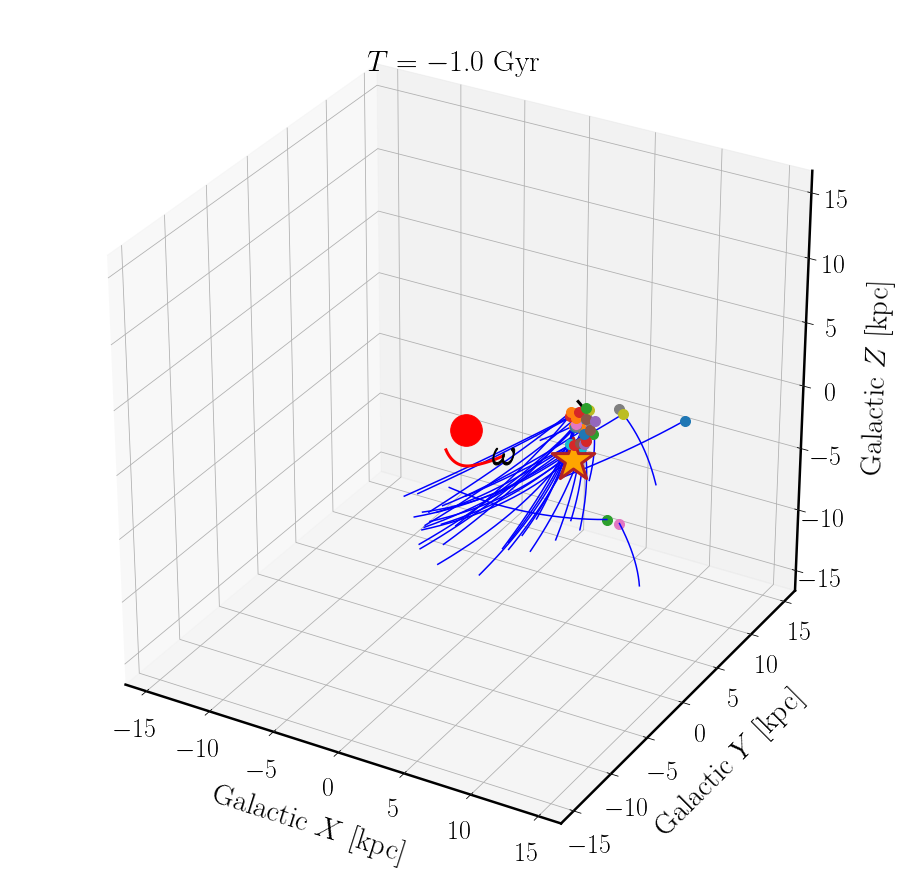

In [555]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from mpl_toolkits.mplot3d import Axes3D
from astropy import units

fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
nstars = size(S1,0)
kpc = units.kpc
kms = units.km/units.s
deg = units.deg

Flip = True

ts = linspace(0.0,1.0,500)

for i in range(0,nstars):
    R = S1.GalR[i]
    vR = S1.GalRVel[i]
    vT = S1.GalTVel[i]
    z = S1.Galz[i]
    vz = S1.GalzVel[i]
    phi = S1.Galphi[i]
    o = Orbit(vxvv=[R*kpc,vR*kms,vT*kms,z*kpc,vz*kms,phi*deg])
    if Flip:
        o.flip()
    o.integrate(ts,MWPotential2014)
    ax.plot(o.x(ts),o.y(ts),o.z(ts),'b-')
    ax.scatter(o.x(0),o.y(),o.z(),marker='o',s=100)

# Sun
t_long = linspace(0.0,100.0,500)
o_sun = Orbit(vxvv=[Sun[0]*kpc,0.0*kms,232.0*kms,0.0*kpc,0.0*kms,0.0*deg])
o_sun.integrate(ts,MWPotential2014)
if Flip:
    o_sun.flip()
ax.plot(o_sun.x(ts),o_sun.y(ts),o_sun.z(ts),'k-',lw=3)
ax.scatter(o_sun.x(0),o_sun.y(),o_sun.z(),s=2000,marker='*',color='orange',edgecolor='firebrick',lw=3)

# Omega-cen
o_cen = Orbit.from_name('Omega Cen')
o_cen.integrate(ts,MWPotential2014)
if Flip:
    o_cen.flip()
ax.plot(o_cen.x(ts),o_cen.y(ts),o_cen.z(ts),'r-',lw=3)
ax.scatter(o_cen.x(0),o_cen.y(),o_cen.z(),s=500,marker='$\omega$',color='k')
    
# Galactic center
ax.scatter(0, 0, 0,marker='o',s=1000,color='r')

ax.set_xlim3d([-16,16])
ax.set_ylim3d([-16,16])
ax.set_zlim3d([-16,16])
ax.set_xlabel('Galactic $X$ [kpc]',fontsize=30,labelpad=30)
ax.set_ylabel('Galactic $Y$ [kpc]',fontsize=30,labelpad=30)
ax.set_zlabel('Galactic $Z$ [kpc]',fontsize=30,labelpad=30)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=26)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax.set_title(r'$T = -$'+str(ts[-1])+' Gyr',fontsize=30)
plt.show()

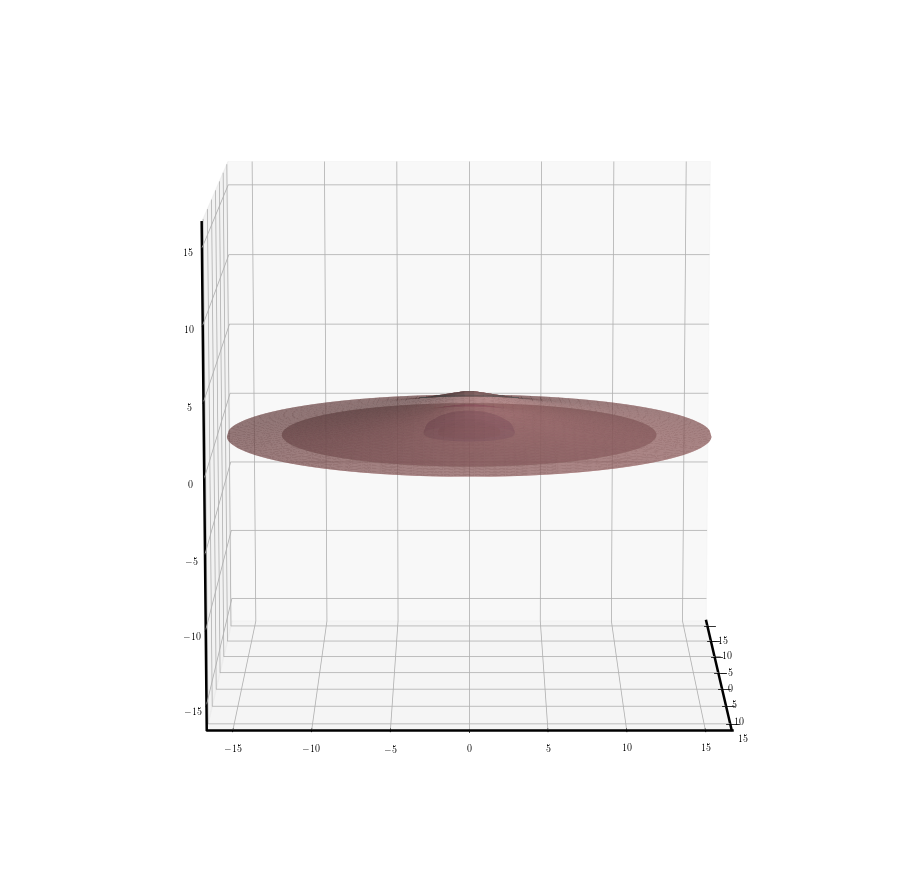

In [766]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')

def rhoR(x,y,z):
    R = sqrt(x**2 + y**2)
    rp = sqrt(R**2.0+(z/0.5)**2.0)
    return 95.6*1000/((1.0+(rp/0.075))**1.8)*exp(-(rp/2.1)**2.0)

def rhoz1(x,y,z):
    R = sqrt(x**2 + y**2+z**2.0)
    return 816.6/(2*0.3)*exp(-abs(z)/0.3 - R/2.6)

def rhoz2(x,y,z):
    R = sqrt(x**2 + y**2)
    return 209.5/(2*0.9)*exp(-abs(z)/0.9 - R/3.6)

def rho_full(x,y,z):
    return rhoR(x,y,z)+rhoz1(x,y,z)+rhoz2(x,y,z)

# Make data.
xmin = -16.0
xmax = 16.0
ymin = -16.0
ymax = 16.0
zmin = 0.0
zmax = 4.0
ni = 50
X, Y, Z = meshgrid(linspace(xmin,xmax,ni),linspace(ymin,ymax,ni),linspace(zmin,zmax,ni))
verts, faces, _, _ = measure.marching_cubes_lewiner(rhoR(X,Y,Z), rhoR(3.0,0.0,0.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)

verts, faces, _, _ = measure.marching_cubes_lewiner(rhoR(X,Y,Z), rhoR(2.0,0.0,0.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)


verts, faces, _, _ = measure.marching_cubes_lewiner(rho_full(X,Y,Z), rho_full(0.0,0.0,2.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)

verts, faces, _, _ = measure.marching_cubes_lewiner(rho_full(X,Y,Z), rho_full(0.0,0.0,3.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)



verts, faces, _, _ = measure.marching_cubes_lewiner(rhoR(X,Y,-Z), rhoR(3.0,0.0,0.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)

verts, faces, _, _ = measure.marching_cubes_lewiner(rhoR(X,Y,-Z), rhoR(2.0,0.0,0.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)


verts, faces, _, _ = measure.marching_cubes_lewiner(rho_full(X,Y,-Z), rho_full(0.0,0.0,2.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)

verts, faces, _, _ = measure.marching_cubes_lewiner(rho_full(X,Y,-Z), rho_full(0.0,0.0,3.0),spacing=(1.0, 1.0, 1.0))
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=None,alpha=0.5)



ax.view_init(elev=10.0, azim=0.0) #Reproduce view

ax.set_xlim3d([-16,16])
ax.set_ylim3d([-16,16])
ax.set_zlim3d([-16,16])
plt.show()



In [658]:
amin(rhoR(X,Y,Z))

1.1909166841036576

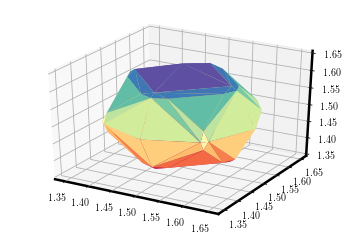

In [672]:
import numpy as np
from numpy import sin, cos, pi
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def fun(x, y, z):
    return sqrt(x**2.0 + y**2.0 + z**2.0)

x, y, z = np.mgrid[-1:1:31j, -1:1:31j, -1:1:31j]
vol = fun(x, y, z)
verts, faces, _, _ = measure.marching_cubes(vol, 0.1, spacing=(0.1, 0.1, 0.1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)
plt.show()

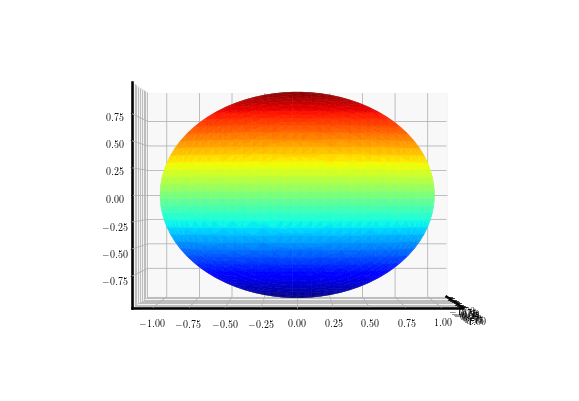

In [721]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
    

def fun(x, y, z):
    return sqrt(x**2.0 + y**2.0 + z**2.0)

xmin = -1.0
xmax = 1.0
ymin = -1.0
ymax = 1.0
zmin = -1.0
zmax = 1.0
ni = 30
x, y, z = meshgrid(linspace(xmin,xmax,ni),linspace(ymin,ymax,ni),linspace(zmin,zmax,ni))
vol = fun(x, y, z)
step = 1
v = 1.0

sel = np.arange(0,np.shape(vol)[0],step)

verts, faces, _, _ = measure.marching_cubes(vol[np.ix_(sel,sel,sel)], v, spacing=(1.0, 1.0, 1.0))

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111, projection='3d')
xverts = verts[:, 0]*(xmax-xmin)/(ni-1) + xmin
yverts = verts[:, 1]*(ymax-ymin)/(ni-1) + ymin
zverts = verts[:, 2]*(zmax-zmin)/(ni-1) + zmin
ax.plot_trisurf(xverts, yverts, faces, zverts, lw=.1, cmap="jet")
ax.view_init(elev=0.0, azim=0.0) #Reproduce view
plt.show()



In [720]:
print amax(vol),amin(vol)

1.73205080757 0.0597258899162


In [718]:
x

array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       ..., 
       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1., 